# Practical Machine Learning Assignment 2 Part A
Ryan Haggerty

The goal of this assignment is to solve regression and classification problems using the
following models on two types of data: numeric and text.
- Part A: Numeric Data - Regression Problem – Linear Regression using the
Stochastic Gradient Descent algorithm
- Part B: Natural Language Processing - Text Data - Classification Problem – KNearest Neighbors 

### Dataset
##### Description: 
The energy efficiency dataset EnergyEfficiency.xlsx is created to perform energy analysis.
The dataset comprises 768 samples and 8 features (X1 to X8). It has two real-valued
target variables (Y1 and Y2), i.e., heating load and cooling load, respectively. For this task, only the heating load will be predicted.

##### Input variables:
- X1: Relative Compactness
- X2: Surface Area
- X3: Wall Area
- X4: Roof Area
- X5: Overall Height
- X6: Orientation
- X7: Glazing Area
- X8: Glazing Area Distribution


##### Output variables: 
- Y1: Heating Load
- Y2: Cooling Load

Only Y1 will be used.


In [35]:
# Import python modules
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor

### Load Data & Displat Dataset Information

In [23]:
# Load data
df = pd.read_csv('/Users/ryguy/Documents/UNL/Classes/Practical Machine Learning/A02/Dataset-Assignment2/EnergyEfficiency.csv', header=0)
df.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28


In [24]:
# Check for missing values in the dataset
df.isna().values.any()

True

In [25]:
# Remove the rows with missing values 
df = df.dropna(axis=0)

### Data Pre-processing


In [27]:
# Create a deep copy of the dataframe for Experiment 2
df_main = df.copy()

# Create input and output matrices
X = df.drop(['Y1','Y2'],axis=1)
y = df['Y1']

# Convert X and y into numpy arrays
X = np.asarray(X)
y = np.asarray(y)

print("\nData Matrix (X) Type: ", X.dtype)
print("Label Array (y) Type: ", y.dtype)


Data Matrix (X) Type:  float64
Label Array (y) Type:  float64


In [28]:
# Partition the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features
from sklearn.preprocessing import scale
X_train=scale(X_train)
X_test=scale(X_test)

# Experiment 1

Create a Polynomial Regression model and train it using SGD with optimal hyperparameters.

In [78]:
%%time
warnings.filterwarnings('ignore')

# Create a Pipeline object
sgd_pipeline = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the"fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate':['constant','optimal']}

# Create a GridSearchCV object and perform hyperparameter tuning
sgd = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd.fit(X_train, y_train)

# Get the optimal hyperparameters
params_optimal_sgd = sgd.best_params_

print("Best Score (negative mean squared error): %f" % sgd.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd)
print("\n")

Fitting 10 folds for each of 960 candidates, totalling 9600 fits
Best Score (negative mean squared error): -0.449353
Optimal Hyperparameter Values:  {'poly__degree': 4, 'sgd__alpha': 0.001, 'sgd__eta0': 0.001, 'sgd__l1_ratio': 1, 'sgd__learning_rate': 'constant', 'sgd__max_iter': 500}


Wall time: 6min 35s


### Optimal Model Evaluation

In [79]:
# Training data: Make prediction 
y_train_predicted_sgd = sgd.predict(X_train)

print("Train: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_sgd))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_sgd))

# Test data: Make prediction 
y_test_predicted = sgd.predict(X_test)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Train: Mean squared error: 0.24
Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: 1.00

Test: Mean squared error: 118.40
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: -0.07


Create a learning curve using the optimal model.

In [71]:
# Clone the optimal model for varying training size using GridSearchCV results
sgdbest = SGDRegressor(loss='squared_loss',penalty='elasticnet', alpha=0.001, l1_ratio=1,max_iter=500, learning_rate='constant', eta0=0.001)

No. of Original Features:  8
No. of Augmented Features:  494


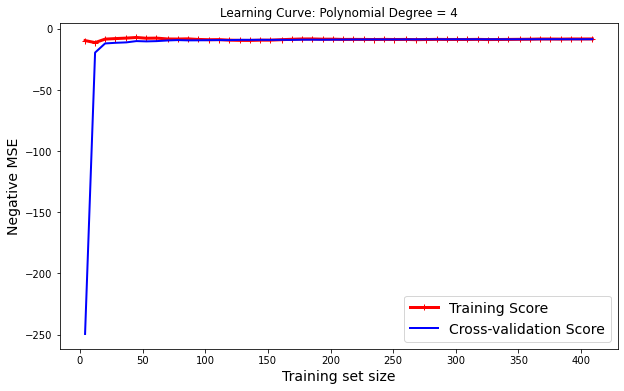

In [73]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = 4


# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])


scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)

# Train the best model with varying training sizes
train_sizes, train_scores, val_scores = learning_curve(sgdbest, X_train, y_train, cv=3, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
                                                                                                                                                                                                       
                                                        
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve: Polynomial Degree = %d" % poly_degree)
plt.show()

## Experiment 2

Using the deep copy of the initial dataframe, we will select subsets of features to train a model on using the optimal hyperparameters with the goal of increasing test performance (increasing test R^2 and decresing test MSE). First, we will perform feature correlation to help in choosing the feature subsets.

In [57]:
# Find feature correlation to target column
df_main.corr()['Y1'].sort_values(ascending=False)

Y1    1.000000
Y2    0.975862
X5    0.889431
X1    0.622272
X3    0.455671
X7    0.269841
X8    0.087368
X6   -0.002587
X2   -0.658120
X4   -0.861828
Name: Y1, dtype: float64

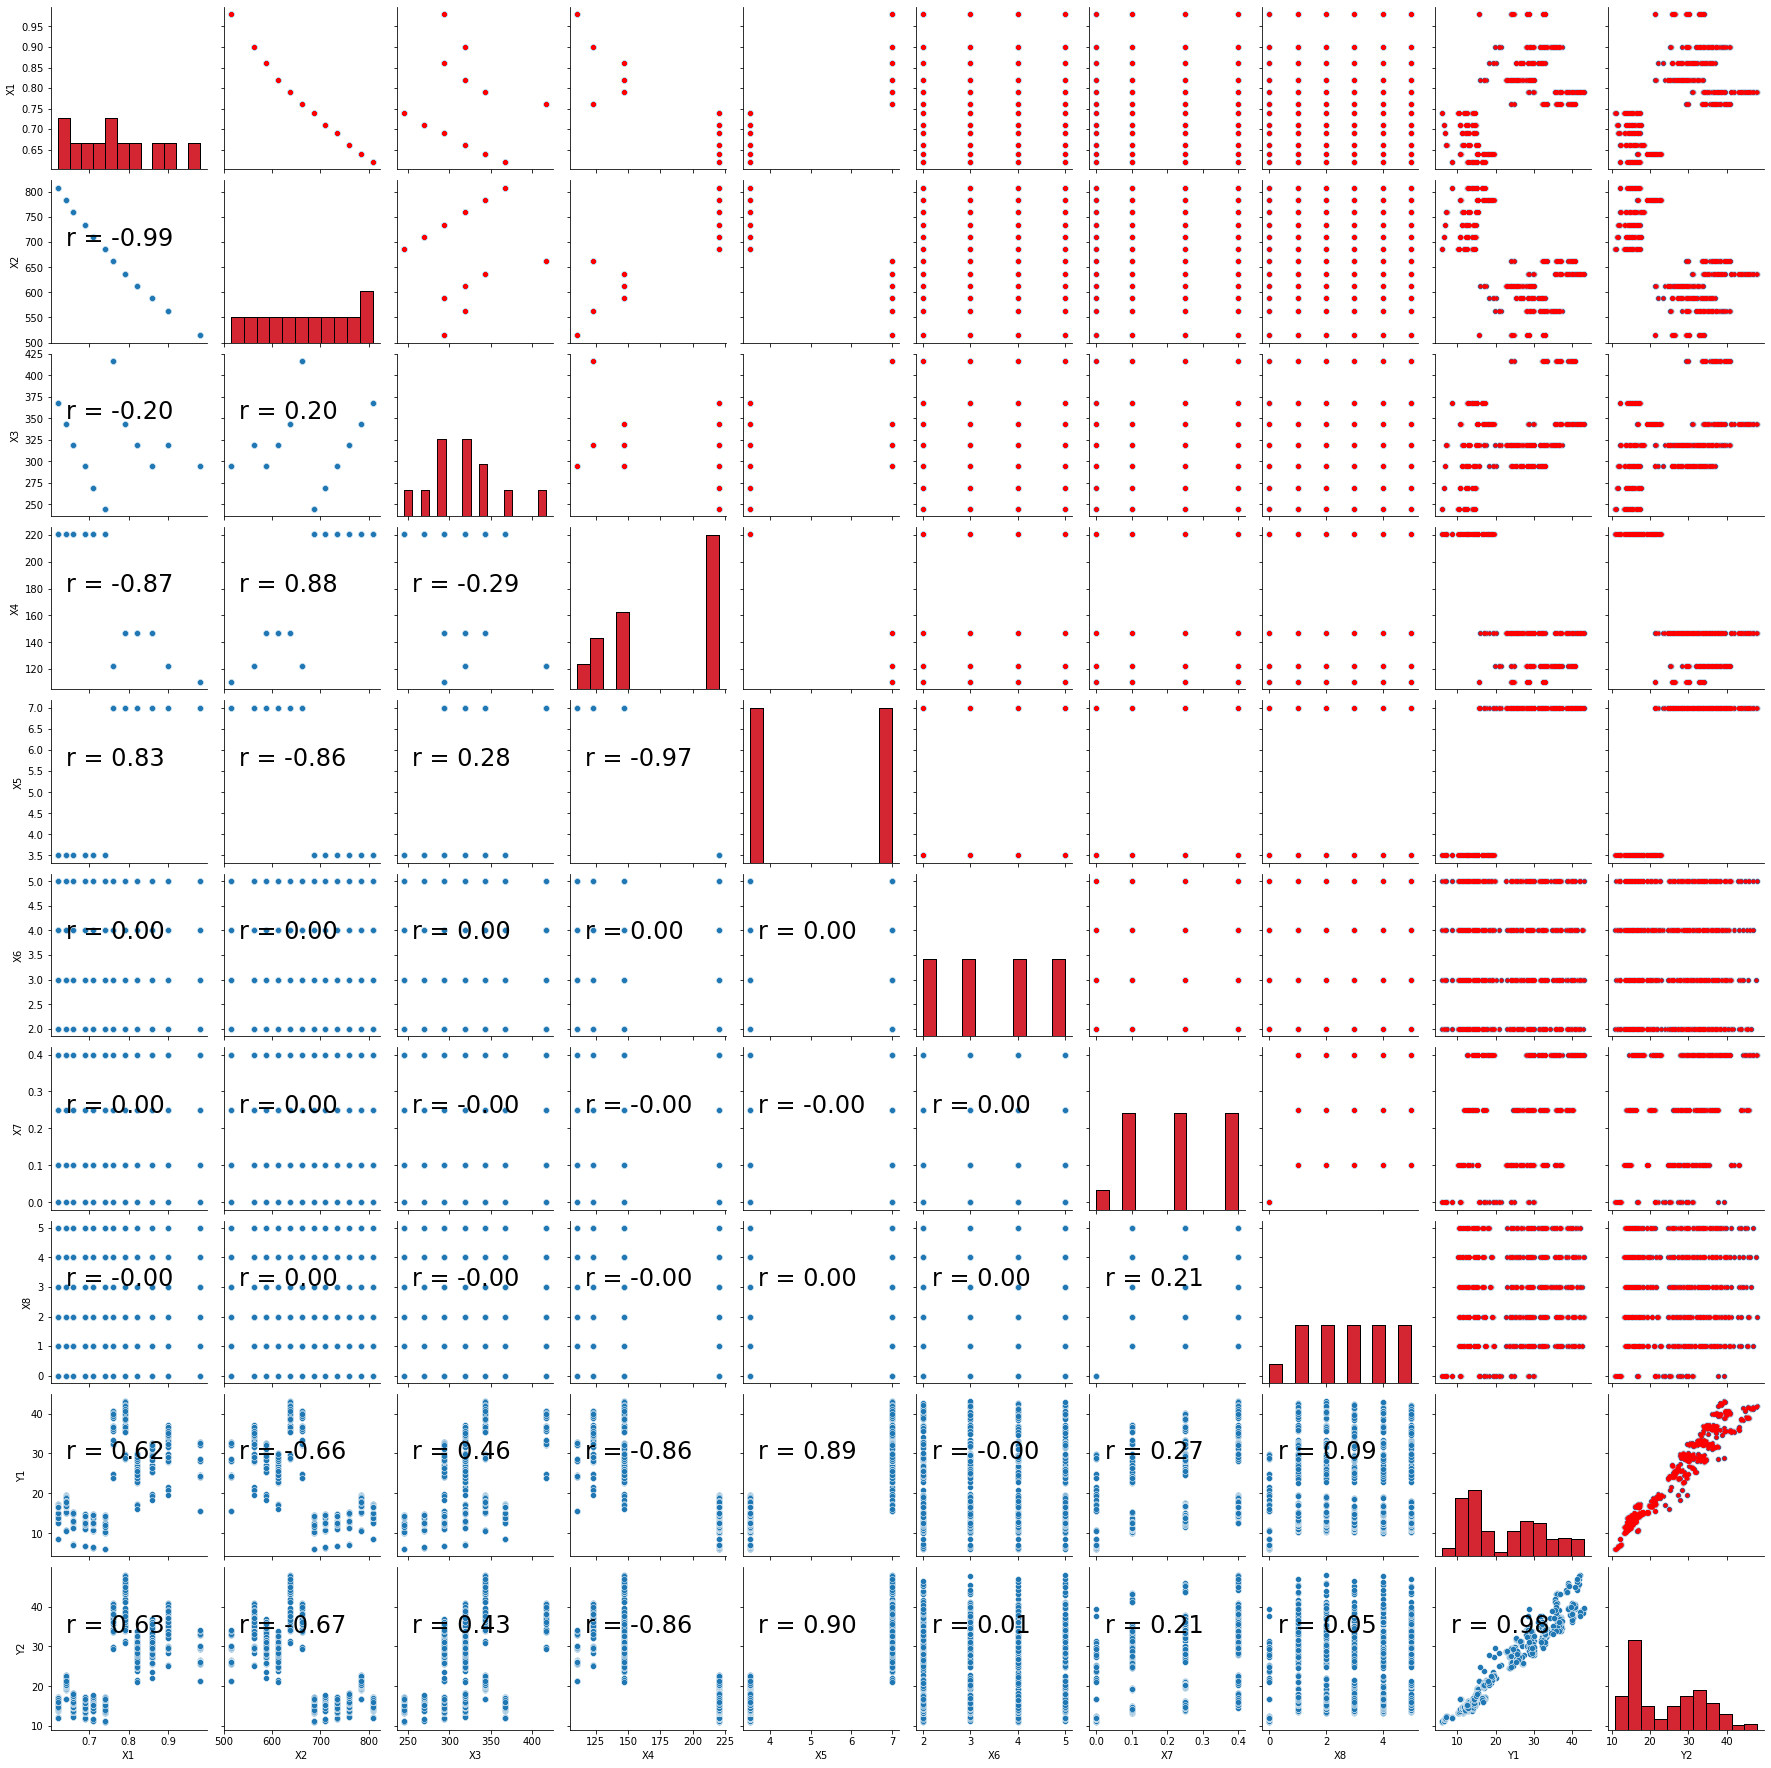

In [58]:
# Find correlation between features
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair plot
g = sns.pairplot(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
#g.map_diag(sns.distplot, kde=False, color = 'red') # distplot is deprecated
#g.map_diag(sns.displot, kde=False, color = 'red')
g.map_diag(sns.histplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
#g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

X2 and X1 seem like redundant features, so we will drop X1 since it has the lower correlation to Y1. Also, X6 and X8 have very low correlation to the target variable, with X6 having the lowest. Our feature subsets will be:
- all except X1
- all except X6
- all except X8
- all except X1 and X6
- all except X1 and X8

In [59]:
# Create input and output matrices
X1 = df_main.drop(['X1','Y1','Y2'],axis=1)
y1 = df_main['Y1']
X2 = df_main.drop(['X6','Y1','Y2'],axis=1)
y2 = df_main['Y1']
X3 = df_main.drop(['X8','Y1','Y2'],axis=1)
y3 = df_main['Y1']
X4 = df_main.drop(['X1','X6','Y1','Y2'],axis=1)
y4 = df_main['Y1']
X5 = df_main.drop(['X1','X8','Y1','Y2'],axis=1)
y5 = df_main['Y1']

# Convert X and y into numpy arrays
X1 = np.asarray(X1)
y1 = np.asarray(y1)
X2 = np.asarray(X2)
y2 = np.asarray(y2)
X3 = np.asarray(X3)
y3 = np.asarray(y3)
X4 = np.asarray(X4)
y4 = np.asarray(y4)
X5 = np.asarray(X5)
y5 = np.asarray(y5)

# Partition the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=0)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=0)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=0)

# Standardize the features
from sklearn.preprocessing import scale
X_train1=scale(X_train1)
X_test1=scale(X_test1)
X_train2=scale(X_train2)
X_test2=scale(X_test2)
X_train3=scale(X_train3)
X_test3=scale(X_test3)
X_train4=scale(X_train4)
X_test4=scale(X_test4)
X_train5=scale(X_train5)
X_test5=scale(X_test5)

In [65]:
%%time
# Subset 1
warnings.filterwarnings('ignore')

# Create a Pipeline object
sgd_pipeline1 = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the"fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4, 5],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate':['constant','optimal']}

# Create a GridSearchCV object and perform hyperparameter tuning
# Set CV to 5
sgd1 = GridSearchCV(sgd_pipeline1, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd1.fit(X_train1, y_train1)

# Get the optimal hyperparameters
params_optimal_sgd1 = sgd1.best_params_

print("Best Score (negative mean squared error): %f" % sgd1.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd1)
print("\n")


print('\n-------------Model Evaulation------------')
# Training data: Make prediction 
y_train_predicted_sgd1 = sgd1.predict(X_train1)
print("\nTrain: Mean squared error: %.2f"
      % mean_squared_error(y_train1, y_train_predicted_sgd1))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train1, y_train_predicted_sgd1))

# Test data: Make prediction 
y_test_predicted1 = sgd.predict(X_test1)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test1, y_test_predicted1))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test1, y_test_predicted1))

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Score (negative mean squared error): -0.624223
Optimal Hyperparameter Values:  {'poly__degree': 4, 'sgd__alpha': 0.001, 'sgd__eta0': 0.001, 'sgd__l1_ratio': 1, 'sgd__learning_rate': 'constant', 'sgd__max_iter': 1000}



-------------Model Evaulation------------

Train: Mean squared error: 0.32
Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: 1.00

Test: Mean squared error: 169.33
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: -0.53
Wall time: 4min 33s


In [ ]:
%%time
# Subset 2
warnings.filterwarnings('ignore')

# Create a Pipeline object
sgd_pipeline2 = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the"fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4, 5],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate':['constant','optimal']}

# Create a GridSearchCV object and perform hyperparameter tuning
# Set CV to 5
sgd2 = GridSearchCV(sgd_pipeline2, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd2.fit(X_train2, y_train2)

# Get the optimal hyperparameters
params_optimal_sgd2 = sgd2.best_params_

print("Best Score (negative mean squared error): %f" % sgd2.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd2)
print("\n")


print('\n-------------Model Evaulation------------')
# Training data: Make prediction 
y_train_predicted_sgd2 = sgd2.predict(X_train2)
print("\nTrain: Mean squared error: %.2f"
      % mean_squared_error(y_train2, y_train_predicted_sgd2))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train2, y_train_predicted_sgd2))

# Test data: Make prediction 
y_test_predicted2 = sgd.predict(X_test2)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test2, y_test_predicted2))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test2, y_test_predicted2))

In [ ]:
%%time
# Subset 3
warnings.filterwarnings('ignore')

# Create a Pipeline object
sgd_pipeline3 = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the"fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4, 5],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate':['constant','optimal']}

# Create a GridSearchCV object and perform hyperparameter tuning
# Set CV to 5
sgd3 = GridSearchCV(sgd_pipeline3, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd3.fit(X_train3, y_train3)

# Get the optimal hyperparameters
params_optimal_sgd3 = sgd1.best_params_

print("Best Score (negative mean squared error): %f" % sgd3.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd3)
print("\n")


print('\n-------------Model Evaulation------------')
# Training data: Make prediction 
y_train_predicted_sgd3 = sgd3.predict(X_train3)
print("\nTrain: Mean squared error: %.2f"
      % mean_squared_error(y_train3, y_train_predicted_sgd3))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train3, y_train_predicted_sgd3))

# Test data: Make prediction 
y_test_predicted3 = sgd.predict(X_test3)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test3, y_test_predicted3))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test3, y_test_predicted3))

In [ ]:
%%time
# Subset 4
warnings.filterwarnings('ignore')

# Create a Pipeline object
sgd_pipeline4 = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the"fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4, 5],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate':['constant','optimal']}

# Create a GridSearchCV object and perform hyperparameter tuning
# Set CV to 5
sgd4 = GridSearchCV(sgd_pipeline4, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd4.fit(X_train4, y_train4)

# Get the optimal hyperparameters
params_optimal_sgd4 = sgd4.best_params_

print("Best Score (negative mean squared error): %f" % sgd4.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd4)
print("\n")


print('\n-------------Model Evaulation------------')
# Training data: Make prediction 
y_train_predicted_sgd4 = sgd1.predict(X_train4)
print("\nTrain: Mean squared error: %.2f"
      % mean_squared_error(y_train4, y_train_predicted_sgd4))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train4, y_train_predicted_sgd4))

# Test data: Make prediction 
y_test_predicted4 = sgd.predict(X_test4)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test4, y_test_predicted4))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test4, y_test_predicted4))

In [ ]:
%%time
# Subset 5
warnings.filterwarnings('ignore')

# Create a Pipeline object
sgd_pipeline5 = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the"fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4, 5],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate':['constant','optimal']}

# Create a GridSearchCV object and perform hyperparameter tuning
# Set CV to 5
sgd5 = GridSearchCV(sgd_pipeline5, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd5.fit(X_train5, y_train5)

# Get the optimal hyperparameters
params_optimal_sgd5 = sgd5.best_params_

print("Best Score (negative mean squared error): %f" % sgd5.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd5)
print("\n")


print('\n-------------Model Evaulation------------')
# Training data: Make prediction 
y_train_predicted_sgd5 = sgd5.predict(X_train5)
print("\nTrain: Mean squared error: %.2f"
      % mean_squared_error(y_train5, y_train_predicted_sgd5))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train5, y_train_predicted_sgd5))

# Test data: Make prediction 
y_test_predicted5 = sgd.predict(X_test5)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test5, y_test_predicted5))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test5, y_test_predicted5))